In [1]:
import pysmile
import pysmile_license
import numpy as np
import pandas as pd

from df_plot import plot_df 
from info_value_to_net import info_value_to_net
from get_info_values import conditional_mutual_info, pointwise_conditional_mutual_info, cond_kl_divergence
from save_info_values import save_info_values
from plot_cond_mut_info import plot_cond_mut_info

np.seterr(divide='ignore', invalid = 'ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

## Using information-related metrics as value functions for a medical test:
Let $X, T, Y$ be random variables describing the results of screening, the results of the colonoscopy and the presence of CRC, respectively; and Z and C decision variables representing the first decision of screening and the decision of colonoscopy. A value function that we could use would be $$V(X,T,Y | Z=z, C=c) = I(X,Y | Z = z) + I(T,Y | C = c)$$ which measures the mutual information of $X$ and $Y$ and the correspondent to $T$ and $Y$. This quantity represents the amount of uncertainty of $Y$ that could be explained by the other variable. 

Check if adding this quantities is correct or if I have to reformulate the value function. 

In [3]:
# Read the network
net = pysmile.Network()
net.read_file("genie_models/Basic_ID_screening_current.xdsl")

### **Conditional Mutual Information** 

$$ \begin{align*} I(X,Y|Z=z) &= H(X|Z=z) - H(X|Y, Z=z) = \\ 
& = -\sum_{x} p(x|z) \log{p(x|z)} + \sum_{y} p(y|z) \sum_{x} p(x|y,z) \log{p(x|y,z)} = \\
& = \left( \sum_x \sum_y \left( p(y|z) p(x| y,z) \log{ \frac{p(x |y,z)}{\sum_y p(y|z) p(x| y,z)}} \right) \right) = \\
& = \sum_x \sum_y \left( p(y) p(x| y,z) \log{ \frac{p(x |y,z)}{\sum_y p(y) p(x| y,z)}} \right) 
\end{align*}$$

In [3]:
net.set_evidence("CRC", False)
p_CRC_false = net.prob_evidence()

net.set_evidence("CRC", True)
p_CRC_true = net.prob_evidence()

In [4]:
p_y = np.array([p_CRC_false, p_CRC_true])
H_y = np.sum(p_y * np.log(1 / p_y) )
H_y

0.005921053223493746

In [5]:
cond_mut_info_scr, cond_mut_info_col = conditional_mutual_info(net)

print("Conditional Mutual Information for Screening:")
cond_mut_info_scr

Conditional Mutual Information for Screening:


CRC                       False                                            \
Screening          No_screening     gFOBT       FIT Blood_based Stool_DNA   
No_pred_screening  3.625619e-10  0.000000  0.000000    0.000000  0.000000   
Predicted_False    0.000000e+00  0.000307  0.000514    0.000410  0.000567   
Predicted_True     0.000000e+00 -0.000305 -0.000510   -0.000408 -0.000566   

CRC                                                True                      \
Screening               CTC Colon_capsule  No_screening     gFOBT       FIT   
No_pred_screening  0.000000      0.000000  2.607914e-13  0.000000  0.000000   
Predicted_False    0.000496      0.000568  0.000000e+00 -0.000227 -0.000243   
Predicted_True    -0.000494     -0.000565  0.000000e+00  0.000972  0.001660   

CRC                                                              
Screening         Blood_based Stool_DNA       CTC Colon_capsule  
No_pred_screening    0.000000  0.000000  0.000000      0.000000  
Predicted_False     -0.000240 -0.000134 -0.000215     -0.000183  
Predicted_True       0.000943  0.001277  0.001138      0.001488

In [6]:
cond_mut_info_scr.values.sum(axis = 0).reshape(2,7).sum(axis = 0)

array([3.62822661e-10, 7.46509329e-04, 1.42087679e-03, 7.03583080e-04,
       1.14496961e-03, 9.25060991e-04, 1.30732295e-03])

In [7]:
print("Conditional Mutual Information for Colonoscopy:")
cond_mut_info_col

Conditional Mutual Information for Colonoscopy:


CRC                       False                       True            
Colonoscopy      No_Colonoscopy Colonoscopy No_Colonoscopy Colonoscopy
no_pred            3.625619e-10    0.000000   2.607914e-13    0.000000
colon_pred_false   0.000000e+00    0.000690   0.000000e+00   -0.000075
colon_pred_true    0.000000e+00   -0.000667   0.000000e+00    0.003143

In [8]:
'''net = info_value_to_net(cond_mut_info_scr, cond_mut_info_col, net)
net.write_file("genie_models/Basic_ID_screening_22052024.xdsl")'''

'net = info_value_to_net(cond_mut_info_scr, cond_mut_info_col, net)\nnet.write_file("genie_models/Basic_ID_screening_22052024.xdsl")'

### **Pointwise conditional mutual information**

Mutual Information between two events conditioned on another, aka, **pointwise conditional mutual information**: $$ \log \frac{p(x,y|z)}{p(x|z)p(y|z)} $$

In [4]:
df_value_scr, df_value_col = save_info_values(net, weighted=True)

In [5]:
df_value_scr

Age                        age_2_young                                 \
Alcohol                           high                                  
Diabetes                         False                                  
Hyperchol_                       False                                  
Hypertension                     False                                  
Sex                                  M                                  
Smoking                sm_1_not_smoker                                  
CRC                              False                                  
Screening                 No_screening                                  
Results_of_Screening No_pred_screening Predicted_False Predicted_True   
Value                              0.0             0.0            0.0   

Age                                                                    \
Alcohol                                                                 
Diabetes                                                                
Hyperchol_                                                              
Hypertension                                                            
Sex                                                                     
Smoking                                                                 
CRC                                                                     
Screening                        gFOBT                                  
Results_of_Screening No_pred_screening Predicted_False Predicted_True   
Value                              0.0        0.000056      -0.002482   

Age                                                                    \
Alcohol                                                                 
Diabetes                                                                
Hyperchol_                                                              
Hypertension                                                            
Sex                                                                     
Smoking                                                                 
CRC                                                                     
Screening                          FIT                                  
Results_of_Screening No_pred_screening Predicted_False Predicted_True   
Value                              0.0        0.000095      -0.002686   

Age                                     ... age_5_old_adult                    \
Alcohol                                 ...             low                     
Diabetes                                ...            True                     
Hyperchol_                              ...            True                     
Hypertension                            ...            True                     
Sex                                     ...               W                     
Smoking                                 ...  sm_3_ex_smoker                     
CRC                                     ...            True                     
Screening                  Blood_based  ...     Blood_based         Stool_DNA   
Results_of_Screening No_pred_screening  ...  Predicted_True No_pred_screening   
Value                              0.0  ...        0.000864               0.0   

Age                                                                    \
Alcohol                                                                 
Diabetes                                                                
Hyperchol_                                                              
Hypertension                                                            
Sex                                                                     
Smoking                                                                 
CRC                                                                     
Screening                                                         CTC   
Results_of_Screening Predicted_False Pr

In [8]:
net = info_value_to_net(df_value_scr, df_value_col, net)
net.write_file("genie_models/Basic_ID_screening_23052024_prueba.xdsl")

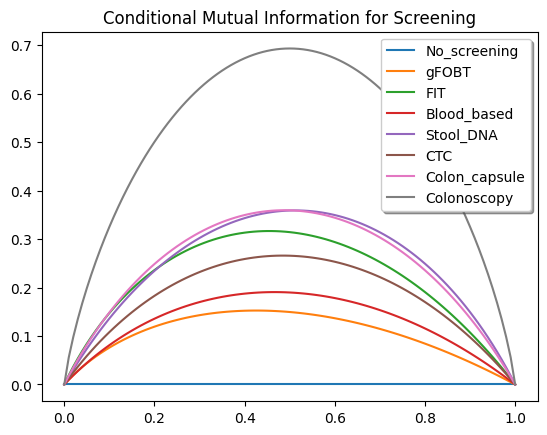

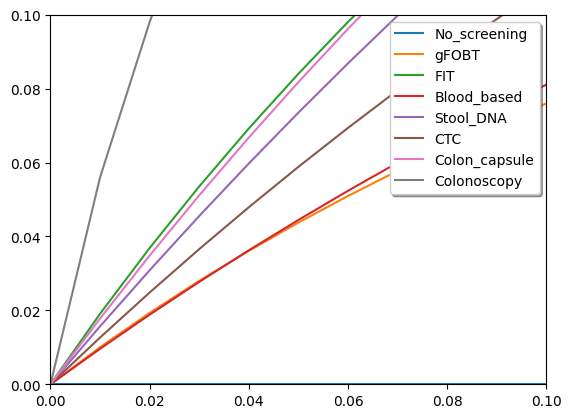

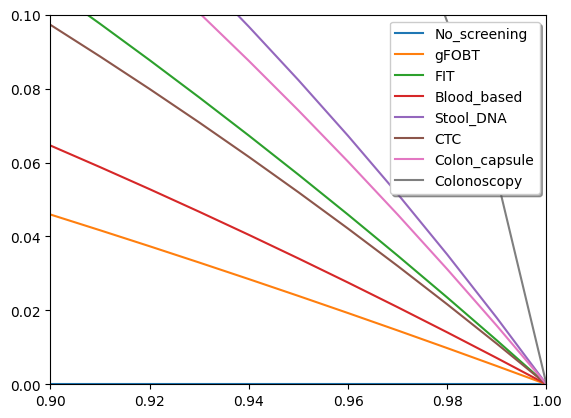

In [6]:
plot_cond_mut_info(net)

#### **Normalized pointwise conditional mutual information**

$$ \frac{ \left(\log \frac{p(x,y|z)}{p(x|z)p(y|z)} \right) }{\log p(x,y|z)} $$

In [54]:
norm_point_cond_mut_info_scr, norm_point_cond_mut_info_col = pointwise_conditional_mutual_info(net, normalize = True)

In [55]:
print("Normalized Pointwise Conditional Mutual Information for Screening:")
norm_point_cond_mut_info_scr

Normalized Pointwise Conditional Mutual Information for Screening:


CRC                       False                                            \
Screening          No_screening     gFOBT       FIT Blood_based Stool_DNA   
No_pred_screening  5.045907e-07  0.000000  0.000000    0.000000  0.000000   
Predicted_False    0.000000e+00  0.013700  0.015092    0.004739  0.004531   
Predicted_True     0.000000e+00 -0.003638 -0.004442   -0.001886 -0.002100   

CRC                                                True                      \
Screening               CTC Colon_capsule  No_screening     gFOBT       FIT   
No_pred_screening  0.000000      0.000000  5.012783e-11  0.000000  0.000000   
Predicted_False    0.004754      0.007341  0.000000e+00 -0.073417 -0.156671   
Predicted_True    -0.002037     -0.002800  0.000000e+00  0.373836  0.409094   

CRC                                                              
Screening         Blood_based Stool_DNA       CTC Colon_capsule  
No_pred_screening    0.000000  0.000000  0.000000      0.000000  
Predicted_False     -0.118321 -0.246832 -0.168677     -0.210841  
Predicted_True       0.259737  0.263125  0.265327      0.322533

In [56]:
print("Normalized Pointwise Conditional Mutual Information for Colonoscopy:")
norm_point_cond_mut_info_col

Normalized Pointwise Conditional Mutual Information for Colonoscopy:


CRC                       False                       True            
Colonoscopy      No_Colonoscopy Colonoscopy No_Colonoscopy Colonoscopy
no_pred            5.045907e-07    0.000000   5.012783e-11    0.000000
colon_pred_false   0.000000e+00    0.064743   0.000000e+00   -0.325358
colon_pred_true    0.000000e+00   -0.014487   0.000000e+00    0.620216

In [57]:
'''net = info_value_to_net(norm_point_cond_mut_info_scr, norm_point_cond_mut_info_col, net)
net.write_file("genie_models/Basic_ID_screening_22052024.xdsl")'''

---
#### Normalized conditional mutual information

There exist several ways of normalizing the mutual information, but it can be shown that the tightest

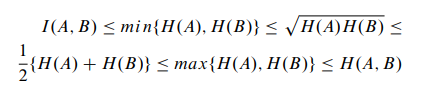

### **Mutual Information** (without conditioning on screening)

$$ \begin{align*} I(X,Y) &= H(X) - H(X|Y) = \\ 
& = -\sum_{x} p(x) \log{p(x)} + \sum_{y} p(y) \sum_{x} p(x|y) \log{p(x|y)} = \\
& = \left( \sum_x \sum_y \left( p(y|z) p(x| y,z) \log{ \frac{p(x |y,z)}{\sum_y p(y|z) p(x| y,z)}} \right) \right) = \\
& = \sum_x \sum_y \left( \sum_z \frac{1}{|Z|} \left( p(y) p(x| y,z) \log{ \frac{\sum_z p(x |y,z)}{\sum_z \sum_y p(y) p(x| y,z)}} \right) \right) 
\end{align*}$$

#### **- Screening**

In [58]:
p_x_yz = np.array(net.get_node_definition("Results_of_Screening")).reshape(2,7,3)

p_x_y = p_x_yz.mean(axis=1)

p_y = np.array([p_CRC_false, p_CRC_true])
p_y = np.repeat(p_y, 3).reshape(2,3)

p_x = np.repeat((p_y * p_x_y).sum(axis=0) , 2).reshape(3,2).transpose()

mut_info_scr = (p_y * p_x_y) * np.log(p_x_y / p_x)

mut_info_scr = np.nan_to_num(mut_info_scr, 0)

pd.DataFrame(mut_info_scr.flatten()).transpose().to_csv("value_of_info_csv/mut_info_scr.csv")

print("Mutual Information for Screening:")
df_plotted = plot_df(mut_info_scr, net, ["Results_of_Screening", "CRC"], mod="mi")
df_plotted

Mutual Information for Screening:


,False,True
No_pred_screening,5.179455e-11,3.725591e-14
Predicted_False,4.088006e-04,-2.022738e-04
Predicted_True,-4.074548e-04,1.025395e-03


In [59]:
df_plotted.sum().sum()

0.0008244673000626431

#### **- Colonoscopy**

In [60]:
p_t_yc = np.array(net.get_node_definition("Results_of_Colonoscopy")).reshape(2,2,3)
p_t_yc = np.swapaxes(p_t_yc,0,1)

p_t_y = p_t_yc.mean(axis = 1)

p_y = np.array([p_CRC_false, p_CRC_true])
p_y = np.repeat(p_y, 3).reshape(2,3)

p_t = np.repeat((p_y * p_t_y).sum(axis=0) , 2).reshape(3,2).transpose()

mut_info_col = (p_y * p_t_y) * np.log(p_t_y / p_t)
mut_info_col = np.nan_to_num(mut_info_col, 0)

pd.DataFrame(mut_info_col.flatten()).transpose().to_csv("value_of_info_csv/mut_info_col.csv")

print("Mutual Information for Colonoscopy:")
df_plotted = plot_df(mut_info_col, net, ["Results_of_Colonoscopy", "CRC"], mod="mi")
df_plotted

Mutual Information for Colonoscopy:


,False,True
no_pred,1.812809e-10,1.303957e-13
colon_pred_false,3.448890e-04,-3.769102e-05
colon_pred_true,-3.333939e-04,1.571531e-03


### **Pointwise Mutual Information:**

#### **- Screening**

In [42]:
point_mi_scr = np.log( p_x_yz.reshape((2,7,3)).mean(axis=1) / p_x_z.mean(axis=1) )
point_mi_scr = np.nan_to_num(point_mi_scr, 0)

pd.DataFrame(point_mi_scr.flatten()).transpose().to_csv("value_of_info_csv/point_mut_info_scr.csv")

print("Pointwise Mutual Information for Screening:")
df_plotted = plot_df(point_mi_scr, net, ["Results_of_Screening", "CRC"], mod="mi")
df_plotted

NameError: name 'p_x_z' is not defined

#### **- Colonoscopy**

In [ ]:
point_mi_col = np.log( p_t_yc.reshape((2,2,3)).mean(axis=1) / p_t_c.mean(axis=1) )

point_mi_col = np.nan_to_num(point_mi_col, 0)
pd.DataFrame(point_mi_col.flatten()).transpose().to_csv("value_of_info_csv/point_mut_info_col.csv")

print("Mutual Information for Colonoscopy:")
df_plotted = plot_df(point_mi_col, net, ["Results_of_Colonoscopy", "CRC"], mod="mi")
df_plotted

Mutual Information for Colonoscopy:


,False,True
no_pred,3.628227e-10,3.628227e-10
colon_pred_false,6.972467e-04,-3.495810e+00
colon_pred_true,-6.672675e-02,4.507984e+00


#### **Normalized Pointwise Mutual Information**

##### **-Screening**

In [ ]:
norm_point_mi_scr = np.log( p_x_yz.reshape((2,7,3)).mean(axis=1) / p_x_z.mean(axis=1) ) / - np.log( p_x_yz.reshape((2,7,3)).mean(axis=1) *p_y)
norm_point_mi_scr = np.nan_to_num(norm_point_mi_scr, 0)

pd.DataFrame(norm_point_mi_scr.flatten()).transpose().to_csv("value_of_info_csv/norm_point_mut_info_scr.csv")

print("Normalized Pointwise Mutual Information for Screening:")
df_plotted = plot_df(norm_point_mi_scr, net, ["Results_of_Screening", "CRC"], mod="mi")
df_plotted

Normalized Pointwise Mutual Information for Screening:


,False,True
No_pred_screening,1.863850e-10,3.950653e-11
Predicted_False,2.190147e-03,-1.455669e-01
Predicted_True,-2.247825e-03,2.916054e-01


#### **- Colonoscopy**

In [ ]:
norm_point_mi_col = np.log( p_t_yc.reshape((2,2,3)).mean(axis=1) / p_t_c.mean(axis=1) )  /  - np.log( p_t_yc.reshape((2,2,3)).mean(axis = 1) * p_y)

norm_point_mi_col = np.nan_to_num(norm_point_mi_col, 0)
pd.DataFrame(norm_point_mi_col.flatten()).transpose().to_csv("value_of_info_csv/norm_point_mut_info_col.csv")

print("Normalized Mutual Information for Colonoscopy:")
df_plotted = plot_df(norm_point_mi_col, net, ["Results_of_Colonoscopy", "CRC"], mod="mi")
df_plotted

Normalized Mutual Information for Colonoscopy:


,False,True
no_pred,5.229000e-10,4.574685e-11
colon_pred_false,9.905246e-04,-3.056405e-01
colon_pred_true,-1.259224e-02,5.662191e-01


### **Conditioned KL-Divergence**

In [ ]:
cond_kl_divergence_scr, cond_kl_divergence_col = cond_kl_divergence(net)

In [ ]:
print("Conditional Kullback-Leibler Divergence for Screening:")
cond_kl_divergence_scr

Conditional Kullback-Leibler Divergence for Screening:


CRC                       False                                            \
Screening          No_screening     gFOBT       FIT Blood_based Stool_DNA   
No_pred_screening  3.625619e-10  0.000000  0.000000    0.000000  0.000000   
Predicted_False    0.000000e+00  0.000314  0.000533    0.000450  0.000655   
Predicted_True     0.000000e+00 -0.013685 -0.014789   -0.004518 -0.004202   

CRC                                                True                      \
Screening               CTC Colon_capsule  No_screening     gFOBT       FIT   
No_pred_screening  0.000000      0.000000  2.607914e-13  0.000000  0.000000   
Predicted_False    0.000557      0.000617  0.000000e+00 -0.000233 -0.000251   
Predicted_True    -0.004475     -0.007018  0.000000e+00  0.043562  0.048086   

CRC                                                              
Screening         Blood_based Stool_DNA       CTC Colon_capsule  
No_pred_screening    0.000000  0.000000  0.000000      0.000000  
Predicted_False     -0.000264 -0.000155 -0.000241     -0.000199  
Predicted_True       0.010431  0.009493  0.010302      0.018468

In [ ]:
print("Conditional Kullback-Leibler Divergence for Colonoscopy:")
cond_kl_divergence_col

Conditional Kullback-Leibler Divergence for Colonoscopy:


CRC                       False                       True            
Colonoscopy      No_Colonoscopy Colonoscopy No_Colonoscopy Colonoscopy
no_pred            3.625619e-10    0.000000   2.607914e-13    0.000000
colon_pred_false   0.000000e+00    0.000697   0.000000e+00   -0.000076
colon_pred_true    0.000000e+00   -0.062375   0.000000e+00    0.294018

In [22]:
net = info_value_to_net(cond_kl_divergence_scr, cond_kl_divergence_col, net)
net.write_file("genie_models/Basic_ID_screening_22052024.xdsl")

### **KL-Divergence**

#### **- Screening**

In [44]:
p_y = np.array([p_CRC_false, p_CRC_true])
p_y = np.repeat(p_y, 3).reshape(2,3)

p_x_y = p_x_yz.mean(axis=1)
p_xy = p_y*(p_x_y) 
p_y_x = p_xy / p_x

values_KL = p_y_x * np.log(p_y_x / p_y)
values_KL = np.nan_to_num(values_KL, 0)

pd.DataFrame(values_KL.flatten()).transpose().to_csv("value_of_info_csv/kl_div_scr.csv")

print("Kullback-Leibler Divergence for Screening:")
df_plotted = plot_df(values_KL, net, ["Results_of_Screening", "CRC"], mod="mi")
df_plotted

Kullback-Leibler Divergence for Screening:


,False,True
No_pred_screening,3.625619e-10,2.607914e-13
Predicted_False,5.177372e-04,-2.561754e-04
Predicted_True,-6.031734e-03,1.517938e-02


#### **- Colonoscopy**

In [46]:
p_y = np.array([p_CRC_false, p_CRC_true])
p_y = np.repeat(p_y, 3).reshape(2,3) 

p_ty = p_y*(p_t_yc.mean(axis=1))
p_y_t = p_ty / p_t

values_KL = p_y_t * np.log(p_y_t / p_y)
values_KL = np.nan_to_num(values_KL, 0)

pd.DataFrame(values_KL.flatten()).transpose().to_csv("value_of_info_csv/cond_kl_div_col.csv")

print("Conditional Kullback-Leibler Divergence for Colonoscopy:")
df_plotted = plot_df(values_KL, net, ["Results_of_Screening", "CRC", "Colonoscopy"], mod="mi")
df_plotted

Conditional Kullback-Leibler Divergence for Colonoscopy:


,False,True
No_pred_screening,3.625619e-10,2.607914e-13
Predicted_False,6.972315e-04,-7.619659e-05
Predicted_True,-6.237472e-02,2.940180e-01


---


### **Information gain**

In [32]:
net.clear_all_evidence()

net.update_beliefs()

In [33]:
net.set_evidence("CRC", False)
p_CRC_false = net.prob_evidence()

net.set_evidence("CRC", True)
p_CRC_true = net.prob_evidence()

In [34]:
p_r_sc = np.array(net.get_node_definition("Results_of_Screening")).reshape(2,7,3)

p_c = np.array([p_CRC_false, p_CRC_true])
p_c = np.repeat(p_c, 3).reshape(2,3)

In [35]:
sum_p_r_sc = np.array(net.get_node_definition("Results_of_Screening")).reshape(2,7,3).mean(axis = 1)

In [36]:
H_c = - (p_c * np.log(p_c)).sum(axis=0)
H_c

array([0.00592105, 0.00592105, 0.00592105])

In [37]:
p_c = np.array([p_CRC_false, p_CRC_true])
p_c = np.repeat(p_c, 3).reshape(2,3)
p_c

array([[9.99281215e-01, 9.99281215e-01, 9.99281215e-01],
       [7.18784668e-04, 7.18784668e-04, 7.18784668e-04]])

In [38]:
arr = np.repeat((p_c * sum_p_r_sc).sum(axis = 0),2).reshape(3,2).transpose()
arr 

array([[0.14285714, 0.78959101, 0.06755185],
       [0.14285714, 0.78959101, 0.06755185]])

In [39]:
t1 = (p_c * sum_p_r_sc) / arr
t1

array([[9.99281215e-01, 9.99798818e-01, 9.93231129e-01],
       [7.18784669e-04, 2.01181890e-04, 6.76887106e-03]])

In [40]:
H_c_r = -(t1*np.log(t1)).sum(axis = 0)
H_c_r

array([0.00592105, 0.00191348, 0.04055927])

In [41]:
H_c - H_c_r

array([ 3.60674369e-10,  4.00757193e-03, -3.46382175e-02])

### Other alternatives

#### Brier score

In [42]:
df = pd.read_csv("df_2016.csv")

try:
    df.drop(columns = ["Medication", "año_reco", "fpi", "Unnamed: 0"], inplace = True)
except:
    df = df

try:
    df = df[(df["Age"] != "1_very_young") & (df["Age"] != "6_elderly")].copy()
except:
    df = df

try:
    df.rename(columns={"Hyperchol.": "Hyperchol_"}, inplace = True)
except:
    df = df


The following code uses the information for each patient together with the prediction of the screening method (considering randomness in the method, that is, the possibility of making mistakes in the diagnosis) to predict CRC. The motivation is that knowing the screening result could help better diagnosing the patient. However, the task might be difficult due to the class imbalance and thus the probability of a false result being very high. The classification results seem to increase the sensitivity (great) but reduce the specificity (not so great).

Would a slightly different framework aid?? Perhaps performing a colonoscopy after the screening would better the results.

---
Original method: Just use patient data

In [43]:
net.clear_all_evidence()

y_prob_pred = []

for i in range(df.shape[0]):
   
    sample = df.iloc[i].drop(labels = ["CRC"])

    sample_dict = sample.to_dict() 

    for keys, values in sample_dict.items():
        net.set_evidence(keys,values)

    net.update_beliefs()

    crc_probs = net.get_node_value("CRC")

    y_prob_pred.append(crc_probs[1])

KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, PrecisionRecallDisplay, fbeta_score, brier_score_loss
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean

from sklearn.calibration import calibration_curve, CalibrationDisplay


def evaluate(df_test, test_var, y_prob_pred, weights = [[1],[1]], ):

    g_means_iter = []
    sensitivity_iter = []
    specificity_iter = []
    brier_score = []


    test_var = "CRC"
    # df_test = df

    fpr, tpr, thresholds = roc_curve(list(df_test[test_var]*1), y_prob_pred)
    # calculate the g-mean for each threshold
    gmeans = gmean( [tpr, 1-fpr], axis = 0, weights=weights)
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

    g_means_iter.append(gmeans[ix])


    y_pred = np.where(y_prob_pred > thresholds[ix], 1, 0)

    beta = 2
    fbeta = fbeta_score(list(df_test[test_var]*1), y_pred, beta=beta)
    print(f"F_{beta} score =", fbeta)

    roc_display = RocCurveDisplay.from_predictions(list(df_test[test_var]*1), y_prob_pred)


    conf_mat = confusion_matrix(list(df_test[test_var]), y_pred)
    disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.array(sorted(set(df_test[test_var]*1))) )
    disp.plot()

    brier_score.append(brier_score_loss(list(df_test[test_var]*1), y_prob_pred))

    print("Brier loss:", brier_score_loss(list(df_test[test_var]*1), y_prob_pred))


    prob_true, prob_pred = calibration_curve(list(df_test[test_var]*1), y_prob_pred, n_bins = 10, strategy="quantile")
    disp = CalibrationDisplay(prob_true, prob_pred, y_prob_pred)
    disp.plot(name = test_var)

    plt.xlim([0, max(max(prob_pred), max(prob_true))])  #CRC: 0.005, Diabetes: 0.25
    plt.ylim([0, max(max(prob_pred), max(prob_true))])

    dashed =  len(df_test[df_test[test_var] == True]) / len(df_test)
    plt.axvline(x=dashed, linestyle = '--', color='gray') 

    # Show the modified plot
    plt.title(f"Calibration plot for {test_var}")
    plt.show()

    report = classification_report(list(df_test[test_var]*1), y_pred, output_dict=True)

    print(classification_report(list(df_test[test_var]*1), y_pred))

    sensitivity_iter.append(report["1"]["recall"])
    specificity_iter.append(report["0"]["recall"])

    return y_pred, tpr, fpr, thresholds

Best Threshold=0.000836, G-Mean=0.705
F_2 score = 0.007614500478478746


Brier loss: 0.0006410318746597882


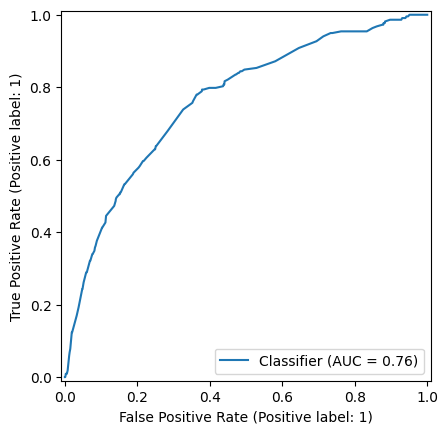

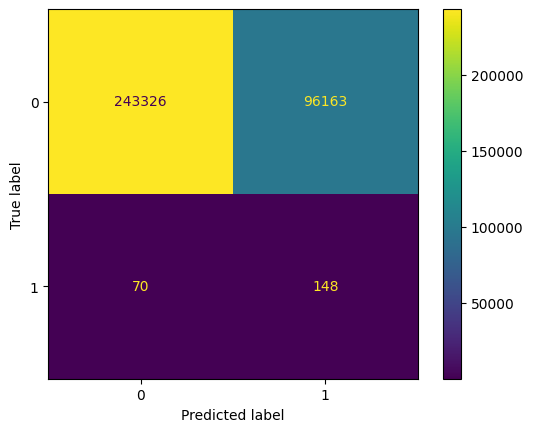

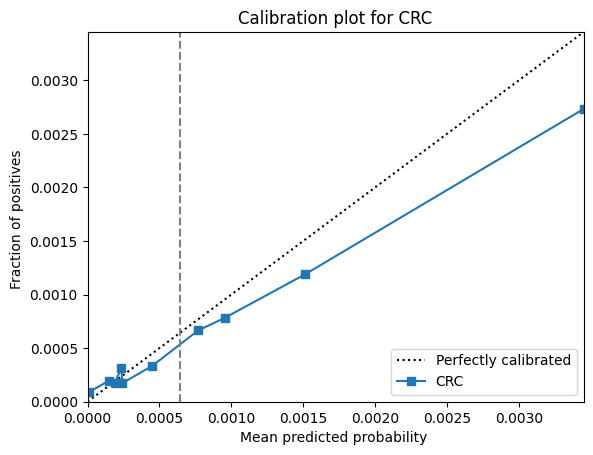

              precision    recall  f1-score   support

           0       1.00      0.72      0.83    339489
           1       0.00      0.68      0.00       218

    accuracy                           0.72    339707
   macro avg       0.50      0.70      0.42    339707
weighted avg       1.00      0.72      0.83    339707



In [ ]:
y_pred, tpr, fpr, thresholds = evaluate(df_test = df, test_var = "CRC", y_prob_pred=y_prob_pred, weights=[[1],[1]])

In [ ]:
def find_thr_sens(df, test_var, y_prob_pred, tpr, fpr, thresholds, minimum_sensitivity):
    g_means_iter = []


    for i in [1,1.5,2,5,10,20,40,80,160]:

        gmeans = gmean( [tpr, 1-fpr], axis = 0, weights=[[i], [1]])
        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)
        print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

        g_means_iter.append(gmeans[ix])


        y_pred = np.where(y_prob_pred > thresholds[ix], 1, 0)

        report = classification_report(list(df[test_var]*1), y_pred, output_dict=True)

        print("Weight =", i)
        print("Sensitivity:", report["1"]["recall"])
        print("Specificity:", report["0"]["recall"])
        print("----------")

        if minimum_sensitivity < report["1"]["recall"]:
            print("Sensitivity:", report["1"]["recall"])
            print("Specificity:", report["0"]["recall"])

            print("Threshold:", thresholds[ix])
            return y_pred, thresholds[ix]
        
    
    return y_pred, thresholds[ix]
    

In [ ]:
y_pred, thr = find_thr_sens(df, "CRC", y_prob_pred, tpr, fpr, thresholds, minimum_sensitivity = 0.9)

Best Threshold=0.000836, G-Mean=0.705


Weight = 1
Sensitivity: 0.6788990825688074
Specificity: 0.7167419268370993
----------
Best Threshold=0.000717, G-Mean=0.720
Weight = 1.5
Sensitivity: 0.7889908256880734
Specificity: 0.6220407730441929
----------
Best Threshold=0.000717, G-Mean=0.732
Weight = 2
Sensitivity: 0.7889908256880734
Specificity: 0.6220407730441929
----------
Best Threshold=0.000253, G-Mean=0.778
Weight = 5
Sensitivity: 0.8440366972477065
Specificity: 0.5118722550657017
----------
Best Threshold=0.000195, G-Mean=0.846
Weight = 10
Sensitivity: 0.9403669724770642
Specificity: 0.28680752542792254
----------
Sensitivity: 0.9403669724770642
Specificity: 0.28680752542792254
Threshold: 0.00019494499999999997


In [ ]:
df[ df["CRC"] == y_pred].head()

,Age,Sex,BMI,Alcohol,Smoking,PA,Depression,Anxiety,Diabetes,Hypertension,Hyperchol_,SD,SES,CRC
14,age_3_young_adult,M,bmi_4_obese,low,sm_2_smoker,PA_1,False,False,False,False,True,SD_2_normal,ses_2,False
18,age_2_young,W,bmi_2_normal,low,sm_1_not_smoker,PA_2,False,True,False,False,False,SD_2_normal,ses_1,False
22,age_4_adult,M,bmi_3_overweight,low,sm_3_ex_smoker,PA_1,False,False,True,False,True,SD_1_short,ses_2,False
30,age_4_adult,W,bmi_3_overweight,low,sm_2_smoker,PA_1,False,False,False,False,True,SD_2_normal,ses_2,False
32,age_5_old_adult,W,bmi_2_normal,low,sm_2_smoker,PA_1,False,False,False,False,True,SD_1_short,ses_1,False


In [ ]:
df_to_screen = df[ df["CRC"] != y_pred ].reset_index(drop = True)
df_to_screen.head()

,Age,Sex,BMI,Alcohol,Smoking,PA,Depression,Anxiety,Diabetes,Hypertension,Hyperchol_,SD,SES,CRC
0,age_3_young_adult,M,bmi_3_overweight,low,sm_1_not_smoker,PA_2,False,False,False,False,False,SD_2_normal,ses_1,False
1,age_4_adult,M,bmi_3_overweight,low,sm_2_smoker,PA_1,False,False,False,False,False,SD_2_normal,ses_1,False
2,age_5_old_adult,M,bmi_4_obese,low,sm_3_ex_smoker,PA_2,False,False,False,True,False,SD_2_normal,ses_1,False
3,age_4_adult,M,bmi_2_normal,low,sm_1_not_smoker,PA_2,False,False,False,False,False,SD_2_normal,ses_1,False
4,age_3_young_adult,M,bmi_3_overweight,low,sm_1_not_smoker,PA_1,False,False,False,False,False,SD_2_normal,ses_1,False


---
Option #1: Do Colonoscopy for FIT positive

In [ ]:
net.clear_all_evidence()
net.set_evidence("Screening", "FIT")

y_prob_pred = []

for i in range(df_to_screen.shape[0]):
    net.clear_evidence("Results_of_Screening")
    net.clear_evidence("Results_of_Colonoscopy")
    net.clear_evidence("Colonoscopy")
   
    sample = df_to_screen.iloc[i].drop(labels = ["CRC"])

    sample_dict = sample.to_dict() 

    for keys, values in sample_dict.items():
        net.set_evidence(keys,values)

    net.update_beliefs()
    
    # Get probabilities of predicting or not CRC, choose one randomly using these probs
    scr_result_probs = net.get_node_value("Results_of_Screening")

    # Note that there is randomness in the method
    random_number = np.random.rand()

    # Step 2: Determine the category based on cumulative probabilities
    cumulative_probabilities = np.cumsum(scr_result_probs)
    category = np.argmax(cumulative_probabilities > random_number)

    net.set_evidence("Results_of_Screening", category)

    if category == 2: # Do a colonoscopy if result of FIT is positive
        
        net.set_evidence("Colonoscopy", "Colonoscopy")

        net.update_beliefs()
        
        col_result_probs = net.get_node_value("Results_of_Colonoscopy")
        random_number = np.random.rand()

        # Step 2: Determine the category based on cumulative probabilities
        cumulative_probabilities = np.cumsum(col_result_probs)
        category = np.argmax(cumulative_probabilities > random_number)

        net.set_evidence("Results_of_Colonoscopy", category)

    elif category == 1:
        net.set_evidence("Colonoscopy", "No_Colonoscopy")

        net.update_beliefs()
        
        col_result_probs = net.get_node_value("Results_of_Colonoscopy")
        random_number = np.random.rand()

        # Step 2: Determine the category based on cumulative probabilities
        cumulative_probabilities = np.cumsum(col_result_probs)
        category = np.argmax(cumulative_probabilities > random_number)

        net.set_evidence("Results_of_Colonoscopy", category)

    net.update_beliefs()

    crc_probs = net.get_node_value("CRC")

    y_prob_pred.append(crc_probs[1])


Best Threshold=inf, G-Mean=0.000
F_2 score = 0.0


Brier loss: 0.0006307265781291622


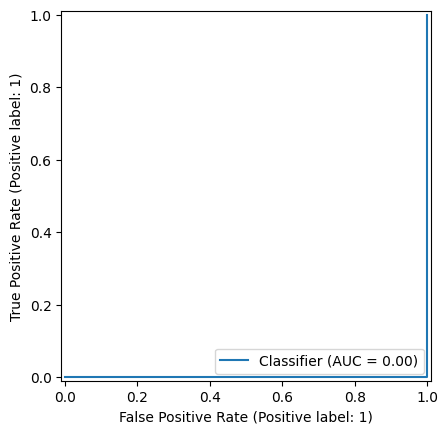

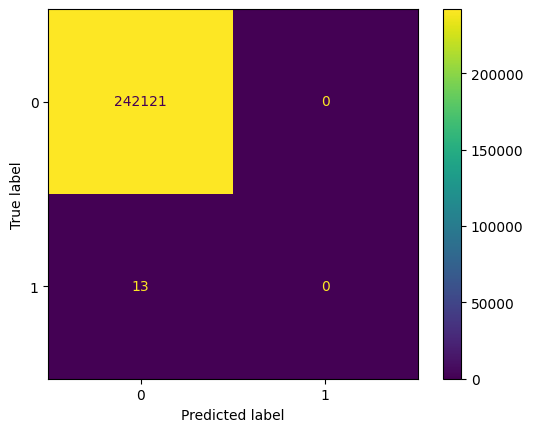

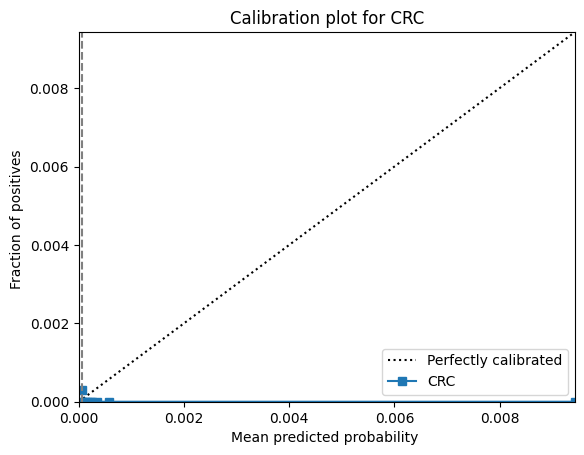

c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    242121
           1       0.00      0.00      0.00        13

    accuracy                           1.00    242134
   macro avg       0.50      0.50      0.50    242134
weighted avg       1.00      1.00      1.00    242134



c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(array([0, 0, 0, ..., 0, 0, 0]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.     

In [ ]:
evaluate(df_test = df_to_screen, test_var = "CRC", y_prob_pred=y_prob_pred, weights=[[1],[1]])

---
Option #2 Do colonoscopy to everyone

In [ ]:
net.clear_all_evidence()
net.set_evidence("Screening", "FIT")

y_prob_pred = []

for i in range(df.shape[0]):
    net.clear_evidence("Results_of_Screening")
    net.clear_evidence("Results_of_Colonoscopy")
    net.clear_evidence("Colonoscopy")
    
   
    sample = df.iloc[i].drop(labels = ["CRC"])

    sample_dict = sample.to_dict() 

    for keys, values in sample_dict.items():
        net.set_evidence(keys,values)

    net.update_beliefs()
    
    # Get probabilities of predicting or not CRC, choose one randomly using these probs
    scr_result_probs = net.get_node_value("Results_of_Screening")

    # Note that there is randomness in the method
    random_number = np.random.rand()

    # Step 2: Determine the category based on cumulative probabilities
    cumulative_probabilities = np.cumsum(scr_result_probs)
    category = np.argmax(cumulative_probabilities > random_number)

    net.set_evidence("Results_of_Screening", category)

    # Do a colonoscopy to everyone.
        
    net.set_evidence("Colonoscopy", "Colonoscopy")

    net.update_beliefs()
    
    col_result_probs = net.get_node_value("Results_of_Colonoscopy")
    random_number = np.random.rand()

    # Step 2: Determine the category based on cumulative probabilities
    cumulative_probabilities = np.cumsum(col_result_probs)
    category = np.argmax(cumulative_probabilities > random_number)

    net.set_evidence("Results_of_Colonoscopy", category)

    net.update_beliefs()

    crc_probs = net.get_node_value("CRC")

    y_prob_pred.append(crc_probs[1])

In [ ]:
evaluate(df_test = df, test_var = "CRC", y_prob_pred=y_prob_pred, weights=[[1],[1]])

Alternativa: Aumentar la sensibilidad de la clasificación del CRC mediante la red bayesiana a expensas de la especificidad. Después, realizar un test FIT a todos aquellos detectados positivos por la red. Después, hacer colonosocopia a todos los detectados positivos por el FIT. 

Estaríamos utilizando el valor predictivo de la red como paso previo al FIT (de hecho es el argumento principal del uso de los algoritmos predictivos para el diagnóstico). La idea es buena pero quizás nos encontramos con la limitación de que el FIT y la colonoscopia vienen modelizadas en el mismo contexto (la red bayesiana) que el resto de variables y por lo tanto no sea tan evidente su diferencial capacidad diagnóstica.

#### Binary cross entropy

## Pruebas

In [61]:
normalize = False

net.set_evidence("CRC", False)
p_CRC_false = net.prob_evidence()

net.set_evidence("CRC", True)
p_CRC_true = net.prob_evidence()

p_y = np.array([p_CRC_false, p_CRC_true])
H_y = np.sum(p_y * np.log(1 / p_y) )
H_y

0.005921053223493746

In [63]:
# --- Screening -----------------------------------------------------------

p_x_yz = np.array(net.get_node_definition("Results_of_Screening")).reshape(2,7,3)

p_y = np.array([p_CRC_false, p_CRC_true])
p_y = np.repeat(p_y, 21).reshape(2,7,3)

p_x_z = p_y * p_x_yz
p_x_z = np.sum(p_x_z, axis = 0)
p_x_z = np.tile(p_x_z, (2,1)).reshape((2,7,3))

if normalize:
    point_cond_mut_info_scr = np.log( p_x_yz.reshape((2,7,3)) / p_x_z ) /  - np.log( p_x_yz.reshape((2,7,3)) * p_y)
    point_cond_mut_info_scr = np.nan_to_num(point_cond_mut_info_scr, 0)
    pd.DataFrame(point_cond_mut_info_scr.flatten()).transpose().to_csv("value_of_info_csv/norm_point_cond_mut_info_scr.csv")
else:
    point_cond_mut_info_scr = np.log( p_x_yz.reshape((2,7,3)) / p_x_z )
    point_cond_mut_info_scr = np.nan_to_num(point_cond_mut_info_scr, 0)
    pd.DataFrame(point_cond_mut_info_scr.flatten()).transpose().to_csv("value_of_info_csv/point_cond_mut_info_scr.csv")

# Print the DataFrame
df_plotted_scr = plot_df(point_cond_mut_info_scr, net, ["Results_of_Screening", "CRC", "Screening"])
df_plotted_scr

CRC                       False                                            \
Screening          No_screening     gFOBT       FIT Blood_based Stool_DNA   
No_pred_screening  3.628227e-10  0.000000  0.000000    0.000000  0.000000   
Predicted_False    0.000000e+00  0.000315  0.000533    0.000450  0.000655   
Predicted_True     0.000000e+00 -0.013887 -0.015023   -0.004542 -0.004223   

CRC                                                True                      \
Screening               CTC Colon_capsule  No_screening     gFOBT       FIT   
No_pred_screening  0.000000      0.000000  3.628227e-10  0.000000  0.000000   
Predicted_False    0.000557      0.000617  0.000000e+00 -0.575277 -1.351170   
Predicted_True    -0.004499     -0.007073  0.000000e+00  3.004318  3.078689   

CRC                                                              
Screening         Blood_based Stool_DNA       CTC Colon_capsule  
No_pred_screening    0.000000  0.000000  0.000000      0.000000  
Predicted_False     -0.984049 -2.419424 -1.492347     -1.956222  
Predicted_True       1.987888  1.925566  1.979633      2.379394

In [70]:
p_x_yz = np.array(net.get_node_definition("Results_of_Screening")).reshape(2,7,3)
p_x_yz

array([[[1.   , 0.   , 0.   ],
        [0.   , 0.978, 0.022],
        [0.   , 0.966, 0.034],
        [0.   , 0.91 , 0.09 ],
        [0.   , 0.866, 0.134],
        [0.   , 0.89 , 0.11 ],
        [0.   , 0.92 , 0.08 ]],

       [[1.   , 0.   , 0.   ],
        [0.   , 0.55 , 0.45 ],
        [0.   , 0.25 , 0.75 ],
        [0.   , 0.34 , 0.66 ],
        [0.   , 0.077, 0.923],
        [0.   , 0.2  , 0.8  ],
        [0.   , 0.13 , 0.87 ]]])

In [72]:
p_y = np.array([p_CRC_false, p_CRC_true])
p_y = np.repeat(p_y, 21).reshape(2,7,3)
p_y

array([[[9.99281215e-01, 9.99281215e-01, 9.99281215e-01],
        [9.99281215e-01, 9.99281215e-01, 9.99281215e-01],
        [9.99281215e-01, 9.99281215e-01, 9.99281215e-01],
        [9.99281215e-01, 9.99281215e-01, 9.99281215e-01],
        [9.99281215e-01, 9.99281215e-01, 9.99281215e-01],
        [9.99281215e-01, 9.99281215e-01, 9.99281215e-01],
        [9.99281215e-01, 9.99281215e-01, 9.99281215e-01]],

       [[7.18784668e-04, 7.18784668e-04, 7.18784668e-04],
        [7.18784668e-04, 7.18784668e-04, 7.18784668e-04],
        [7.18784668e-04, 7.18784668e-04, 7.18784668e-04],
        [7.18784668e-04, 7.18784668e-04, 7.18784668e-04],
        [7.18784668e-04, 7.18784668e-04, 7.18784668e-04],
        [7.18784668e-04, 7.18784668e-04, 7.18784668e-04],
        [7.18784668e-04, 7.18784668e-04, 7.18784668e-04]]])

In [82]:
p_x_z = p_y * p_x_yz
p_x_z = np.sum(p_x_z, axis = 0)
p_x_z

array([[1.        , 0.        , 0.        ],
       [0.        , 0.97769236, 0.02230764],
       [0.        , 0.96548535, 0.03451465],
       [0.        , 0.90959029, 0.09040971],
       [0.        , 0.86543288, 0.13456712],
       [0.        , 0.88950404, 0.11049596],
       [0.        , 0.91943216, 0.08056784]])

In [77]:
p_x_z = np.tile(p_x_z, (2,1)).reshape((2,7,3))

In [79]:
p_x_yz.reshape((2,7,3))

array([[[1.   , 0.   , 0.   ],
        [0.   , 0.978, 0.022],
        [0.   , 0.966, 0.034],
        [0.   , 0.91 , 0.09 ],
        [0.   , 0.866, 0.134],
        [0.   , 0.89 , 0.11 ],
        [0.   , 0.92 , 0.08 ]],

       [[1.   , 0.   , 0.   ],
        [0.   , 0.55 , 0.45 ],
        [0.   , 0.25 , 0.75 ],
        [0.   , 0.34 , 0.66 ],
        [0.   , 0.077, 0.923],
        [0.   , 0.2  , 0.8  ],
        [0.   , 0.13 , 0.87 ]]])

In [83]:
point_cond_mut_info_scr = np.log( p_x_yz.reshape((2,7,3)) / p_x_z )
point_cond_mut_info_scr = np.nan_to_num(point_cond_mut_info_scr, 0)
point_cond_mut_info_scr

array([[[ 3.62822661e-10,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  3.14610009e-04, -1.38867597e-02],
        [ 0.00000000e+00,  5.32906124e-04, -1.50233415e-02],
        [ 0.00000000e+00,  4.50329505e-04, -4.54197215e-03],
        [ 0.00000000e+00,  6.55089140e-04, -4.22331591e-03],
        [ 0.00000000e+00,  5.57415714e-04, -4.49860591e-03],
        [ 0.00000000e+00,  6.17408190e-04, -7.07292602e-03]],

       [[ 3.62822661e-10,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -5.75276782e-01,  3.00431837e+00],
        [ 0.00000000e+00, -1.35117001e+00,  3.07868934e+00],
        [ 0.00000000e+00, -9.84048652e-01,  1.98788819e+00],
        [ 0.00000000e+00, -2.41942440e+00,  1.92556612e+00],
        [ 0.00000000e+00, -1.49234668e+00,  1.97963276e+00],
        [ 0.00000000e+00, -1.95622181e+00,  2.37939365e+00]]])

In [ ]:
# --- Colonoscopy ---------------------------------------------------------

p_t_yc = np.array(net.get_node_definition("Results_of_Colonoscopy")).reshape(2,2,3)
p_t_yc = np.swapaxes(p_t_yc,0,1)

p_y = np.array([p_CRC_false, p_CRC_true])
p_y = np.repeat(p_y, 6).reshape(2,2,3)

p_t_c = p_y * p_t_yc
p_t_c = np.sum(p_t_c, axis = 0)
p_t_c = np.tile(p_t_c, (2,1)).reshape((2,2,3))

if normalize:
    point_cond_mut_info_col = np.log( p_t_yc.reshape((2,2,3)) / p_t_c ) / - np.log( p_t_yc.reshape((2,2,3)) * p_y)
    point_cond_mut_info_col = np.nan_to_num(point_cond_mut_info_col, 0)
    pd.DataFrame(point_cond_mut_info_col.flatten()).transpose().to_csv("value_of_info_csv/norm_point_cond_mut_info_col.csv")
else:
    point_cond_mut_info_col = np.log( p_t_yc.reshape((2,2,3)) / p_t_c )
    point_cond_mut_info_col = np.nan_to_num(point_cond_mut_info_col, 0)
    pd.DataFrame(point_cond_mut_info_col.flatten()).transpose().to_csv("value_of_info_csv/point_cond_mut_info_col.csv")

# Print the DataFrame
df_plotted_col = plot_df(point_cond_mut_info_col, net, ["Results_of_Colonoscopy", "CRC", "Colonoscopy"])

## Pruebas 2


In [2]:
import pysmile
import pysmile_license
import numpy as np
import pandas as pd

from df_plot import plot_df 
from info_value_to_net import info_value_to_net
from get_info_values import conditional_mutual_info, pointwise_conditional_mutual_info, cond_kl_divergence

np.seterr(divide='ignore', invalid = 'ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [3]:
# Read the network
net = pysmile.Network()
net.read_file("genie_models/Basic_ID_screening_23052024_prueba.xdsl")

In [111]:
# Make an array and iterate over possible values of probabilities

arr = []
i = 0

for prob in np.arange(0, 1.01, 0.01):

    p_CRC_false, p_CRC_true = [1-prob, prob] 

    p_y = np.array([p_CRC_false, p_CRC_true])
    H_y = np.sum(p_y * np.log(1 / p_y) )
    H_y

    p_x_yz = np.array(net.get_node_definition("Results_of_Screening")).reshape(2,7,3)

    p_y = np.array([p_CRC_false, p_CRC_true])
    p_y = np.repeat(p_y, 21).reshape(2,7,3)

    p_x_z = p_y * p_x_yz
    p_x_z = np.sum(p_x_z, axis = 0)
    p_x_z = np.tile(p_x_z, (2,1)).reshape((2,7,3))

    p_x_yz.reshape((2,7,3))

    # Calculate the conditional entropy
    cond_mut_info_scr = (p_y * ( p_x_yz * np.log( p_x_yz.reshape((2,7,3)) / p_x_z ) ).reshape(2,7,3))
    cond_mut_info_scr = np.nan_to_num(cond_mut_info_scr, 0)

    # Save the conditional mutual information for screening
    pd.DataFrame(cond_mut_info_scr.flatten()).transpose().to_csv("value_of_info_csv/cond_mut_info_scr.csv")

    df_plotted_scr = plot_df(cond_mut_info_scr, net, ["Results_of_Screening", "CRC", "Screening"])

    aux_arr_scr = df_plotted_scr.sum(axis = 0).values.reshape(2,7).sum(axis = 0)

    


    # Get the entropy of the target variable given the evidence
    p_t_yc = np.array(net.get_node_definition("Results_of_Colonoscopy")).reshape(2,2,3)
    p_t_yc = np.swapaxes(p_t_yc,0,1)

    p_y = np.array([p_CRC_false, p_CRC_true])
    p_y = np.repeat(p_y, 6).reshape(2,2,3)

    p_t_c = p_y * p_t_yc
    p_t_c = np.sum(p_t_c, axis = 0)
    p_t_c = np.tile(p_t_c, (2,1)).reshape((2,2,3))

    p_t_yc.reshape((2,2,3))

    cond_mut_info_col = (p_y * (p_t_yc * np.log( p_t_yc.reshape((2,2,3)) / p_t_c ) ).reshape(2,2,3))
    cond_mut_info_col = np.nan_to_num(cond_mut_info_col, 0)

    pd.DataFrame((cond_mut_info_col).flatten()).transpose().to_csv("value_of_info_csv/cond_mut_info_col.csv")

    df_plotted_col = plot_df(cond_mut_info_col, net, ["Results_of_Colonoscopy", "CRC", "Colonoscopy"])

    aux_arr_col = df_plotted_col.sum(axis = 0).values.reshape(2,2).sum(axis = 0)
    print(aux_arr_col)

    arr = np.append(arr, np.append(aux_arr_scr, np.expand_dims(aux_arr_col[1], axis = 0) ,0) , 0)  

    # arr = np.append(arr, df_plotted_scr.sum(axis = 0).values.reshape(2,7).sum(axis = 0), 0)
    i +=1


[0. 0.]
[0.         0.03968934]
[0.         0.07437385]
[0.        0.1057478]
[0.         0.13462576]
[0.         0.16149005]
[0.        0.1866602]
[0.         0.21036358]
[0.         0.23277021]
[0.         0.25401199]
[0.         0.27419417]
[0.         0.29340264]
[0.         0.31170875]
[0.         0.32917268]
[0.         0.34584583]
[0.         0.36177257]
[0.         0.37699154]
[0.         0.39153667]
[0.         0.40543796]
[0.         0.41872208]
[0.         0.43141288]
[0.         0.44353178]
[0.        0.4550981]
[0.        0.4661293]
[0.         0.47664127]
[0.         0.48664845]
[0.         0.49616401]
[0.         0.50520001]
[0.         0.51376748]
[0.         0.52187653]
[0.         0.52953645]
[0.         0.53675576]
[0.         0.54354232]
[0.        0.5499033]
[0.         0.55584534]
[0.        0.5613745]
[0.         0.56649634]
[0.         0.57121596]
[0.         0.57553801]
[0.         0.57946673]
[0.         0.58300596]
[0.         0.58615917]
[0.         0.588929

[0. 0.]
[0.         0.03968934]
[0.         0.07437385]
[0.        0.1057478]
[0.         0.13462576]
[0.         0.16149005]
[0.        0.1866602]
[0.         0.21036358]
[0.         0.23277021]
[0.         0.25401199]
[0.         0.27419417]
[0.         0.29340264]
[0.         0.31170875]
[0.         0.32917268]
[0.         0.34584583]
[0.         0.36177257]
[0.         0.37699154]
[0.         0.39153667]
[0.         0.40543796]
[0.         0.41872208]
[0.         0.43141288]
[0.         0.44353178]
[0.        0.4550981]
[0.        0.4661293]
[0.         0.47664127]
[0.         0.48664845]
[0.         0.49616401]
[0.         0.50520001]
[0.         0.51376748]
[0.         0.52187653]
[0.         0.52953645]
[0.         0.53675576]
[0.         0.54354232]
[0.        0.5499033]
[0.         0.55584534]
[0.        0.5613745]
[0.         0.56649634]
[0.         0.57121596]
[0.         0.57553801]
[0.         0.57946673]
[0.         0.58300596]
[0.         0.58615917]
[0.         0.588929

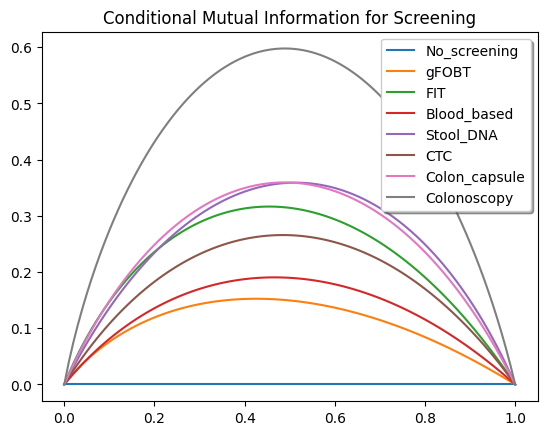

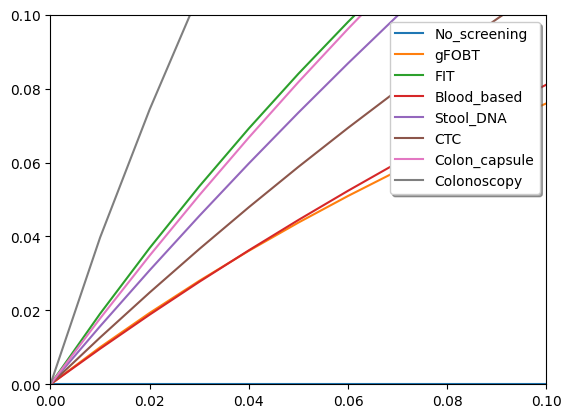

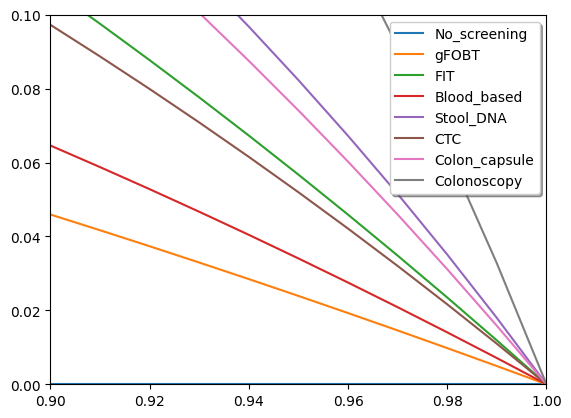

In [4]:
from plot_cond_mut_info import plot_cond_mut_info
plot_cond_mut_info(net)

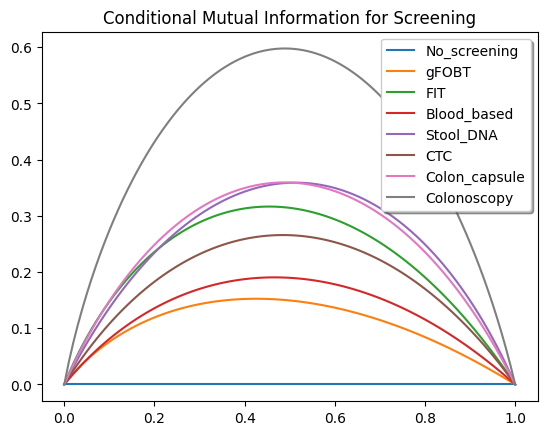

In [117]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
labels = net.get_outcome_ids("Screening") + ["Colonoscopy"]
for screening in range(arr.shape[0]):
    ax.plot(np.arange(0,1.01,0.01), arr[screening], label = f"{labels[screening]}")
    leg = plt.legend(loc='upper right', shadow=True)
    title = "Conditional Mutual Information for Screening"
    plt.title(title)

(0.0, 0.1)

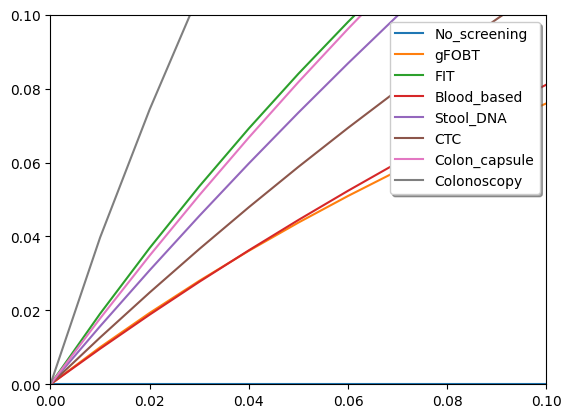

In [119]:
fig, ax = plt.subplots()
labels = net.get_outcome_ids("Screening") + ["Colonoscopy"]
for screening in range(arr.shape[0]):
    ax.plot(np.arange(0,1.01,0.01), arr[screening], label = f"{labels[screening]}")
    leg = plt.legend(loc='upper right', shadow=True)
    
ax.set_xlim(0, 0.1)
ax.set_ylim(0,0.1)

(0.0, 0.1)

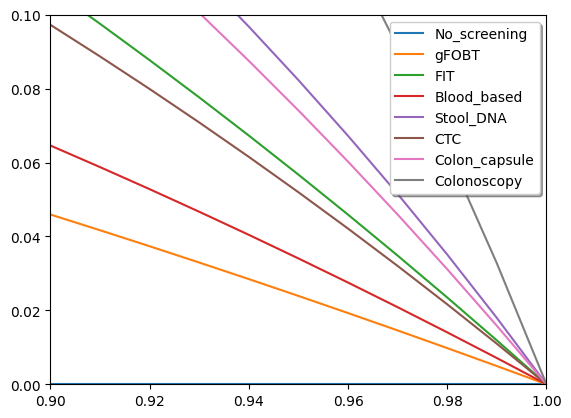

In [120]:
fig, ax = plt.subplots()
labels = net.get_outcome_ids("Screening") + ["Colonoscopy"]
for screening in range(arr.shape[0]):
    ax.plot(np.arange(0,1.01,0.01), arr[screening], label = f"{labels[screening]}")
    leg = plt.legend(loc='upper right', shadow=True)
    
ax.set_xlim(0.90, 1)
ax.set_ylim(0,0.1)

In [30]:
arr.reshape(3,7)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.01001511, 0.01909105, 0.00960805, 0.01568459,
        0.01264841, 0.01780653],
       [0.        , 0.01931124, 0.03687675, 0.01884047, 0.03085767,
        0.02483539, 0.03483367]])

In [23]:
 arr = np.concatenate( (arr, df_plotted_scr.sum(axis = 0).values.reshape(2,7).sum(axis = 0)))

In [20]:
df_plotted_scr.sum(axis = 0).values.reshape(2,7).sum(axis = 0)

array([0., 0., 0., 0., 0., 0., 0.])

In [17]:
df_plotted_scr.sum(axis = 0).values.reshape(2,7).sum(axis = 0)

array([0.        , 0.11926108, 0.23594781, 0.13566049, 0.23434309,
       0.18283448, 0.24847074])